# Extension to Roaming Heat Map with Node Weighting and Self Defined Label

In [1]:
# Added Node Weight(Node Size) to model the change of utilization of a AP station
# Added Self Defined Label to ease visualization 
# As APID cannot be used to uniquely identify an AP and MacAddress is too clumsy

In [2]:
import pandas as pd
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data Processing

In [3]:
#Load in Roamed File
roam_file = "../sortlog/h3c-wx7-20161118/h3c-wx7-20161118-info-formatted/h3c-wx7-20161118-roamed-formatted.csv"
roam_df = pd.read_csv(roam_file, engine='python')
roam_df.info()
roam_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25365 entries, 0 to 25364
Data columns (total 7 columns):
Time              25365 non-null object
StatusCode        25365 non-null object
UserMacAddress    25365 non-null object
FromMacAddress    25365 non-null object
FromAPID          25365 non-null int64
ToMacAddress      25365 non-null object
ToAPID            25365 non-null int64
dtypes: int64(2), object(5)
memory usage: 891.8+ KB


,Time,StatusCode,UserMacAddress,FromMacAddress,FromAPID,ToMacAddress,ToAPID
0,00:00:01,Roamed,58:44:98:21:F3:AD,80:F6:2E:53:E8:53,604,80:F6:2E:53:57:23,603
1,00:00:14,Roamed,58:44:98:21:F3:AD,80:F6:2E:53:57:23,603,00:23:89:60:77:63,194
2,00:00:35,Roamed,DC:41:5F:D9:67:DE,00:23:89:6A:B8:E3,106,80:F6:2E:53:57:23,603
3,00:00:49,Roamed,48:3B:38:09:1F:F8,58:66:BA:AB:71:E2,102,00:23:89:6A:BF:B2,205
4,00:00:52,Roamed,48:3B:38:09:1F:F8,00:23:89:6A:BF:B2,205,58:66:BA:AB:71:F2,102


In [4]:
#Load in Successfully Login File
login_file = "../sortlog/h3c-wx7-20161118/h3c-wx7-20161118-info-formatted/h3c-wx7-20161118-successfully-formatted.csv"
login_df = pd.read_csv(login_file, engine='python')
login_df.info()
login_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303122 entries, 0 to 303121
Data columns (total 7 columns):
Time              303122 non-null object
StatusCode        303122 non-null object
UserName          78385 non-null object
UserMacAddress    303122 non-null object
SSID              294374 non-null object
APID              224727 non-null float64
BSSID             224727 non-null object
dtypes: float64(1), object(6)
memory usage: 9.3+ MB


,Time,StatusCode,UserName,UserMacAddress,SSID,APID,BSSID
0,00:00:00,Successfully Join,1454197190036643,1C:5C:F2:CF:D1:B0,CSL Auto Connect,NaN,NaN
1,00:00:01,Successfully Join,NaN,58:44:98:21:F3:AD,HKU,603.0,80:F6:2E:53:57:23
2,00:00:06,Successfully Join,NaN,74:81:14:99:D4:63,Wi-Fi.HK via HKU,123.0,38:22:D6:AE:F3:92
3,00:00:06,Successfully Join,NaN,84:29:99:69:11:B5,eduroam,106.0,00:23:89:6A:B8:E1
4,00:00:08,Successfully Join,NaN,04:4B:ED:3F:AB:EE,HKU,102.0,58:66:BA:AB:71:F3


In [5]:
# Quite a lot of Login Record with no BSSID(AP Mac Address)
login_df.isna().sum()

Time                   0
StatusCode             0
UserName          224737
UserMacAddress         0
SSID                8748
APID               78395
BSSID              78395
dtype: int64

## Prepare Edge and Edge Weighting

In [6]:
#Graph with Weighting
start_time="00:00:00"
end_time="24:00:00"
data_df = roam_df.where((roam_df["Time"]>=start_time) & (roam_df["Time"]<=end_time))
data_df.dropna(inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25365 entries, 0 to 25364
Data columns (total 7 columns):
Time              25365 non-null object
StatusCode        25365 non-null object
UserMacAddress    25365 non-null object
FromMacAddress    25365 non-null object
FromAPID          25365 non-null int64
ToMacAddress      25365 non-null object
ToAPID            25365 non-null int64
dtypes: int64(2), object(5)
memory usage: 1.1+ MB


In [7]:
#Model Each Roaming as an Edge
roam_edge=[]
for index, row in data_df.iterrows():
    roam_edge.append((row['FromMacAddress'], row['ToMacAddress']))

In [8]:
#Model the number of roam happened in the period by edge weight
edge_weight={}
for edge in roam_edge:
    if edge in edge_weight:
        edge_weight[edge]+=1
    else:
        edge_weight[edge]=1
max_value=1
if edge_weight:
    max_value = max(edge_weight.values())
edge_width_scaling_factor=1/max_value

## Prepare Node Weighting

In [9]:
#Model Change of User of an AP with Node Size = No.of login - No.of disconnect + Roam In - Roam Out (Within the defined time period)
#Absolute number of user cannot be model due to finite amount of data
login_count=login_df['BSSID'].value_counts()
roamin_count=roam_df['ToMacAddress'].value_counts()
roamout_count=roam_df['FromMacAddress'].value_counts()
node_count={}
for mac, count in login_count.iteritems():
    node_count[mac]=count
for mac, count in roamin_count.iteritems():
    if mac in node_count:
        node_count[mac]+=count
    else:
        node_count[mac]=count
for mac, count in roamout_count.iteritems():
    if mac in node_count:
        node_count[mac]-=count
    else:
        node_count[mac]=-1*count

## Frequency Distribution

OrderedDict([(1, 5387), (2, 1466), (3, 672), (4, 378), (5, 227), (6, 128), (7, 105), (8, 89), (9, 59), (12, 41), (10, 38), (11, 36), (14, 29), (13, 23), (15, 19), (16, 19), (19, 16), (21, 16), (20, 13), (17, 12), (22, 12), (18, 12), (24, 9), (29, 6), (28, 6), (27, 5), (35, 5), (25, 5), (32, 4), (30, 4), (34, 3), (31, 3), (47, 3), (33, 3), (37, 3), (42, 3), (45, 3), (23, 3), (63, 2), (40, 2), (48, 2), (41, 2), (52, 2), (26, 2), (93, 1), (91, 1), (306, 1), (308, 1), (70, 1), (175, 1), (105, 1), (39, 1), (133, 1), (128, 1), (248, 1), (142, 1), (73, 1), (69, 1), (49, 1), (38, 1), (177, 1), (84, 1), (64, 1), (82, 1), (54, 1), (160, 1), (50, 1), (43, 1), (53, 1)])


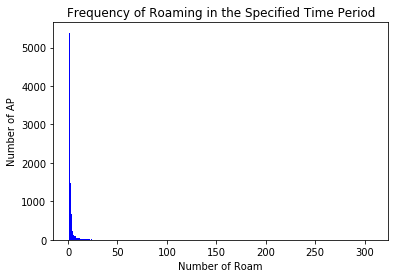

In [10]:
# Frquency of number of roaming of AP
from collections import Counter,OrderedDict
from matplotlib.pyplot import figure
count = Counter(edge_weight.values())
ordered_count = OrderedDict(count.most_common())
print(ordered_count)
plt.bar(count.keys(),count.values(),width=1,color='b')
plt.title('Frequency of Roaming in the Specified Time Period')
plt.xlabel('Number of Roam')
plt.ylabel('Number of AP')
plt.show()

## Graphing

In [11]:
#Create new graph and add edges with weight
#Could add a threshold for node weight
G = nx.Graph() 
weight_threshold=20 #Plot edge with weight(no.of roaming) >threshold
for key in edge_weight:
    if edge_weight[key]>weight_threshold:
        G.add_edge(key[0],key[1],weight=edge_weight[key])

In [12]:
#Add node weight to the graph
node_weight={}
for mac in node_count:
    tmp={}
    tmp['weight']=node_count[mac]
    node_weight[mac]=tmp
nx.set_node_attributes(G, node_weight)

In [13]:
#Label the Node with Self defined ID instead of Mac Address
#APID cannot be used because APID is not an unique identifer of an AP
#The APID of an AP changes throughout the day (unknown reason)
node_label = {}
i=0
for node in G.nodes():
    node_label[node]=i
    i=i+1

## With Self Defined Node Label

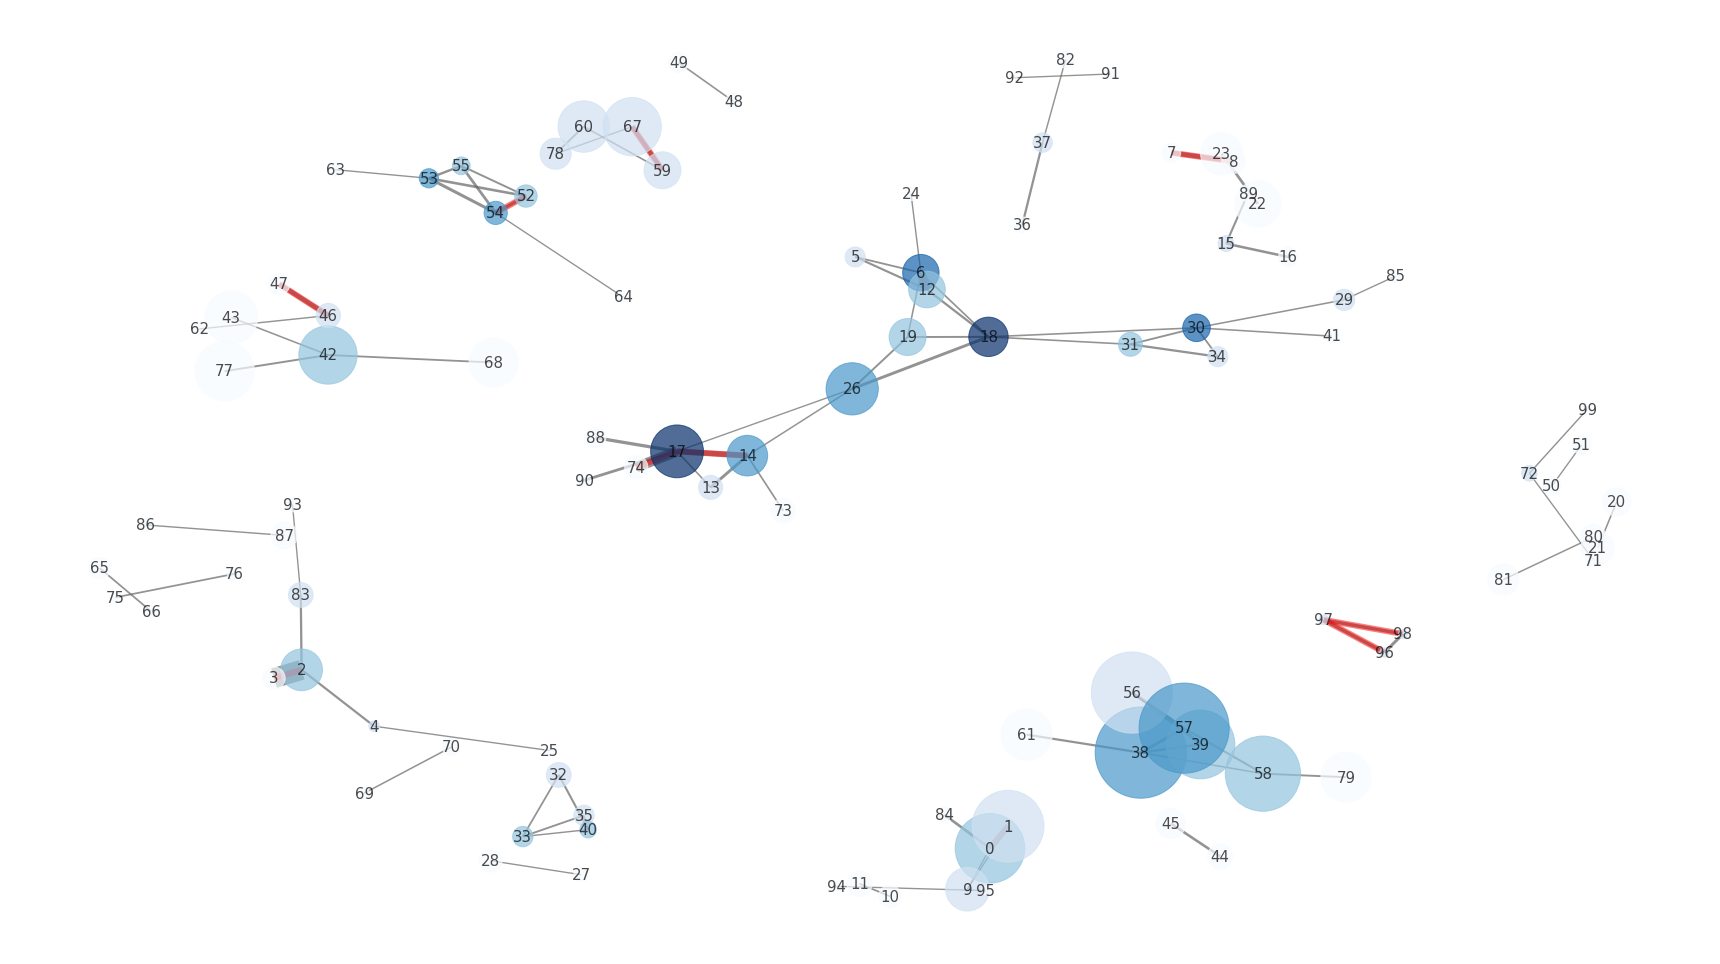

In [14]:
# Draw graph with varying node color, node size, and edge width
# Reference: https://www.cnblogs.com/zhengzhe/p/8574358.html
plt.figure(figsize=(10,7))
node_color = [G.degree(v) for v in G]
#Node size/weight can be used to indicate the change of utilization during start_time to end_time
#Cannot show absolute number of user utilizing the station due to limited size of data

node_size = [1.5*nx.get_node_attributes(G, 'weight')[v] for v in G]
edge_width = [20*edge_width_scaling_factor*G[u][v]['weight'] for u,v in G.edges()]
#Node location can be added to project the map of HKU to the network graph
#Clustering -> Show Node in a specific cluster
pos = nx.spring_layout(G,k=0.7, seed=2)
nx.draw_networkx(G,pos,node_color=node_color, alpha=0.7, node_size=node_size,
                 with_labels=True, labels=node_label, width=edge_width, edge_color='.4', cmap=plt.cm.Blues, font_size=15)

#Threshold of the weight of a node to be coloured Red
color_threshold = 50
greater_than_threshold = [x for x in G.edges(data=True) if x[2]['weight']>color_threshold]
nx.draw_networkx_edges(G, pos, edgelist=greater_than_threshold, edge_color='r', alpha=0.5, width=6)

fig = plt.gcf()
fig.set_size_inches(24,13.5)
plt.axis('off')
plt.tight_layout();

In [15]:
#Node ID on Graph to Mac Address Conversion
labeldict

NameError: name 'labeldict' is not defined

## Trying out bokeh

In [ ]:
# from bokeh.io import output_notebook, show
# from bokeh.plotting import figure
# import networkx as nx
# from bokeh.models import Range1d, Plot
# from bokeh.models.graphs import from_networkx

# # We could use figure here but don't want all the axes and titles
# plot = Plot()

# # Create a Bokeh graph from the NetworkX input using nx.spring_layout
# graph = from_networkx(G,pos,node_color=node_color, alpha=0.7, node_size=node_size,
#                  with_labels=True, labels=labeldict, width=edge_width, edge_color='.4', cmap=plt.cm.Blues, font_size=15)
# plot.renderers.append(graph)

# show(plot)